# Postgres Partitions
- Show the Partitioned tables - Table name and the number of partitions

In [1]:
import sqlalchemy
import pandas as pd
import configparser
import matplotlib.pyplot as plt 

# Read from the Config file
config = configparser.ConfigParser() 
config.read_file(open(r'../ipynb.cfg'))

con_str = config.get('con_str', 'PG_AIRBASES') 
engine = sqlalchemy.create_engine(con_str)

try:
    connection = engine.connect()
    print ("Opened Connection")
except (Exception, sqlalchemy.exc.SQLAlchemyError) as error:
    print("Error while connecting to PostgreSQL database:", error)


Opened Connection


## Partition tables and their size
Notice: To calcualte the size of a partitioned table, or the number of its rows, we must sum the size of all of its child partitions. 

TODO: show the Partition rule using the function pg_get_partkeydef(pg_class.oid) as partition_key

In [2]:
from sqlalchemy import create_engine
from sqlalchemy.exc import SQLAlchemyError

sql_command = """
SELECT 
  pg_inherits.inhparent::regclass AS table_name,
  pg_class.relkind, 
	COUNT(pg_inherits.inhrelid::regclass) AS count_partitions, 
  SUM(pg_class.relpages) as total_pages, 
  SUM(pg_class.reltuples) as total_rows
FROM pg_inherits
	JOIN pg_class
  	ON pg_inherits.inhrelid = pg_class.oid
WHERE pg_class.relkind = 'r'
GROUP BY 
	pg_inherits.inhparent::regclass, 
  pg_class.relkind

"""

try:
    # Execute the SQL command
    df = pd.read_sql_query(sql_command, connection)
    print(df)
except (SQLAlchemyError, ValueError) as e:
    # Handle any errors or raised exceptions
    raise e

  table_name relkind  count_partitions  total_pages  total_rows
0     orders       r                 3          104     14000.0


## Partition Names
The Data Set show the tables and the names of their partitions

TODO: 
- Also show the partition function
- Generate demo data for more than 1 partitioned table. 

In [3]:
sql_command = """
SELECT 
  pg_inherits.inhparent::regclass AS table_name, 
	pg_inherits.inhrelid::regclass AS partition_name, 
  pg_class.oid,
  pg_class.relpages, 
  pg_class.reltuples, 
  pg_get_expr(pg_class.relpartbound, pg_class.oid, true) as partition_expression
FROM pg_inherits
	JOIN pg_class
  	ON pg_inherits.inhrelid = pg_class.oid
WHERE pg_class.relkind = 'r'
ORDER BY pg_inherits.inhparent, pg_inherits.inhrelid;
"""

try:
    # Execute the SQL command
    df_partitions = pd.read_sql_query(sql_command, connection)
    print(df_partitions)
except (SQLAlchemyError, ValueError) as e:
    # Handle any errors or raised exceptions
    raise e

  table_name   partition_name      oid  relpages  reltuples  \
0     orders  orders_y2023m01  2302567        36     4887.0   
1     orders  orders_y2023m02  2302574        33     4386.0   
2     orders  orders_y2023m03  2302581        35     4727.0   

                               partition_expression  
0  FOR VALUES FROM ('2023-01-01') TO ('2023-02-01')  
1  FOR VALUES FROM ('2023-02-01') TO ('2023-03-01')  
2  FOR VALUES FROM ('2023-03-01') TO ('2023-04-01')  


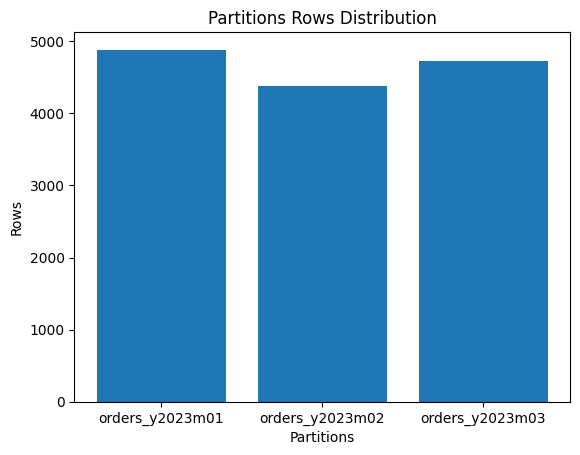

In [4]:
# Filter the dataframe to show only the rows where Value equals 60
selected_table = 'orders'
filtered_df = df_partitions.loc[df_partitions['table_name'] == selected_table]

# Create a bar chart based on the filtered data
plt.bar(filtered_df['partition_name'], filtered_df['reltuples'])
plt.xlabel('Partitions')
plt.ylabel('Rows')
plt.title('Partitions Rows Distribution')

# Display the bar chart
plt.show()